# Grid Snapping

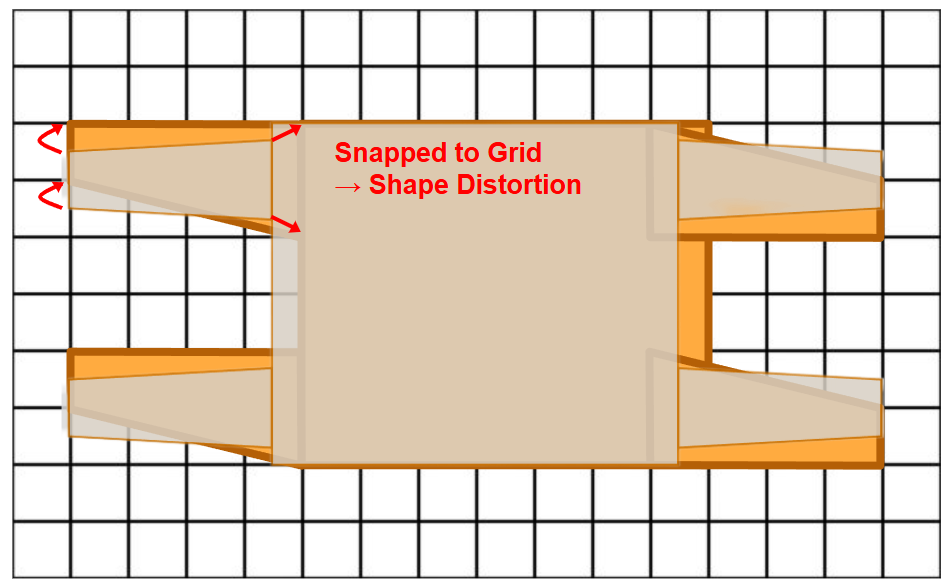


When exporting layouts to GDS, every coordinate is **snapped** to the minimum grid size (1 nm by default in PhotonForge).  
Designs that use exact multiples of this grid retain perfect precision, but any fractional or “half-grid” values are rounded—shifting corners and edges, which can introduce alignment errors or even violate DRC rules.

In this notebook, we will:

1. Build a toy MMI with all dimensions on the 1 nm grid → **perfect fidelity**  
2. Increase the grid size to demonstrate off-grid vertices → **observe the rounding**  
3. Explain why **non-Manhattan** connections and ports should be avoided  
4. Show how to insert **angled segments** while preserving Manhattan-aligned start/end ports to prevent snapping errors  


In [1]:
import numpy as np
import photonforge as pf
pf.config.default_technology = pf.basic_technology()

## Perfect MMI (all dims on 1 nm grid)

Here we build a toy “MMI” whose coordinates are all exact multiples of the 1 nm grid.  
**Note:** these waveguides are unrealistically small—this is **not** a practical MMI design but simply a minimal example to illustrate that, when every dimension lies precisely on the grid, no snapping (rounding) errors occur.


In [2]:
# unit length used for all dimensions in this design
unit = 10e-3  # 0.01 µm = 10 nm

# a tapered waveguide (toy model)
wg = pf.Component("Waveguide")
wg.add(
    (1, 0),
    pf.Polygon(
        [
            (0, 2.5 * unit),
            (3.5 * unit, 2.7 * unit),
            (3.5 * unit, 1.3 * unit),
            (0, 1.5 * unit),
        ]
    ),
)

# a multimode section (toy model)
mm_wg = pf.Component("Multi-mode Waveguide")
mm_wg.add(
    (1, 0),
    pf.Polygon(
        [
            (3.5 * unit, 3 * unit),
            (10.5 * unit, 3 * unit),
            (10.5 * unit, -3 * unit),
            (3.5 * unit, -3 * unit),
        ]
    ),
)

mmi = pf.Component("MMI With 4 Ports")
mmi.add(mm_wg)
# place the four tapers
mmi.add_reference(wg)
mmi.add_reference(wg).translate((0, -4 * unit))
mmi.add_reference(wg).rotate(180, center=(7 * unit, 2 * unit))
mmi.add_reference(wg).rotate(180, center=(7 * unit, 0))

mmi  # visualize

## Snapping Error Due to Coarse Grid

Now we repeat the exact same structure, but this time we **increase the grid size** to match our design units (`unit = 10 nm`).  
This means every point will now snap to the **nearest 10 nm** instead of 1 nm.

Since the polygon coordinates like `2.5 * unit = 25 nm` and `3.1 * unit = 31 nm` are now **not exact multiples of 10 nm**, PhotonForge will round them **up or down**, distorting the shapes.

Again, this example is not a real MMI (the waveguides are far too narrow), but it illustrates the snapping distortion clearly.


In [3]:
pf.config.grid = unit
# a tapered waveguide
wg = pf.Component("Waveguide")
wg.add(
    (1, 0),
    pf.Polygon(
        [
            (0, 2.5 * unit),
            (3.5 * unit, 2.7 * unit),
            (3.5 * unit, 1.3 * unit),
            (0, 1.5 * unit),
        ]
    ),
)

# a multimode section (toy model)
mm_wg = pf.Component("Multi-mode Waveguide")
mm_wg.add(
    (1, 0),
    pf.Polygon(
        [
            (3.5 * unit, 3 * unit),
            (10.5 * unit, 3 * unit),
            (10.5 * unit, -3 * unit),
            (3.5 * unit, -3 * unit),
        ]
    ),
)

mmi = pf.Component("MMI With 4 Ports")
mmi.add(mm_wg)
# place the four taps
mmi.add_reference(wg)
mmi.add_reference(wg).translate((0, -4 * unit))
mmi.add_reference(wg).rotate(180, center=(7 * unit, 2 * unit))
mmi.add_reference(wg).rotate(180, center=(7 * unit, 0))

mmi  # visualize

To avoid unintended distortions, we now reset the grid back to its default **1 nm** value:

In [4]:
pf.config.grid = 1e-3  # Change back to default

## Avoiding Non-Manhattan Port Angles

In integrated photonic layout, it is essential to maintain **Manhattan-aligned ports**—that is, ports with orientations restricted to 0°, 90°, 180°, or 270°.  
Using ports at arbitrary angles (non-Manhattan orientations) can cause their center positions to fall **off the grid**, leading to **snapping errors** when exported to GDS.

The following example uses a **very small test port** (4 nm in length) to clearly illustrate this issue.  
We rotate one instance of the waveguide by 45° and attempt to connect it to an unrotated one.  
Although the connection appears visually aligned, a **small gap remains** between the ports due to the snapping of off-grid coordinates—typically around **1 nm**, which can compromise fabrication or simulation.

This is a subtle but critical issue in precision layout design.


In [5]:
# Define a small port to expose snapping errors
nm = 1e-3

small_port_spec = pf.PortSpec(
    description="4 nm test port",
    width=10 * nm,
    limits=(-10 * nm, 10 * nm),
    path_profiles=[(4 * nm, 0, (1, 0))],
)

# Create the test component
c = pf.Component()

# Straight waveguide with this tiny port
wg = pf.parametric.straight(port_spec=small_port_spec, length=4 * nm)

# Add one rotated by 45°, and one unrotated
wg_ref1 = c.add_reference(wg).rotate(45)
wg_ref2 = c.add_reference(wg)

# Attempt to connect them — a small gap will appear due to non-Manhattan angle
wg_ref2.connect("P0", wg_ref1["P1"])

# Display the component to inspect the connection gap
c

PhotonForge’s `Path` API lets you insert angled segments **between** Manhattan-aligned endpoints by chaining `turn` (or `arc`) and `segment`.  
Here’s how to build a path that:

1. **Starts** at 0° (Manhattan)  
2. **Turns** 45° with a specified bend radius  
3. **Draws** an angled segment at 45°  
4. **Turns** back −45° to finish at 0°  

Because the path’s first and last directions are Manhattan, its ports will snap exactly to grid—even though there’s an interior 45° section.


In [6]:
# Parameters (µm)
wg_width = 0.5
L = 5.0

# Compute the 45° displacement
dx = L / np.sqrt(2)
dy = dx

# Build the path and component
ang_path = (
    pf.Path((0, 0), width=wg_width)
    .turn(45, radius=5)
    .segment((dx, dy), relative=True)
    .turn(-45, radius=5)
)
c = pf.Component("Angled Path Example")
c.add(ang_path)

# Visualize
c